In [18]:
import os
import sys
import torch
import importlib
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from PIL import Image
import yaml
import json
from scipy.spatial.transform import Rotation
import random

In [19]:
# Add the root directory to the path for imports
try:
    project_root = os.path.dirname(os.path.abspath(__file__))
    if project_root not in sys.path:
        sys.path.append(project_root)
except NameError:
    project_root = os.path.abspath('.')
    if project_root not in sys.path:
        sys.path.append(project_root)

In [20]:
# ======== CONFIGURATION ========
CONFIG_MODEL_1 = {
    "name": "Extrapolation Model",
    "dataset_path": "/home/stud/lavingal/storage/slurm/lavingal/LVSM/datasets/re10k/test/full_list.txt",
    "specific_checkpoint": "/home/stud/lavingal/storage/slurm/lavingal/LVSM/experiments/checkpoints/LVSM_re10k_extrapolation_norandom/ckpt_0000000000172000.pt",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "config_file": "/home/stud/lavingal/storage/slurm/lavingal/LVSM/configs/LVSM_scene_decoder_only.yaml",
}

In [21]:
CONFIG_MODEL_2 = {
    "name": "Regular Interpolation Model",
    "dataset_path": "/home/stud/lavingal/storage/slurm/lavingal/LVSM/datasets/re10k/test/full_list.txt",
    "specific_checkpoint": "/home/stud/lavingal/storage/slurm/lavingal/LVSM/experiments/checkpoints/LVSM_scene_decoder_only/ckpt_0000000000246000.pt",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "config_file": "/home/stud/lavingal/storage/slurm/lavingal/LVSM/configs/LVSM_scene_decoder_only.yaml",
}

In [22]:
OUTPUT_DIR = "./rendered_videos"
os.makedirs(OUTPUT_DIR, exist_ok=True)

======== HELPER FUNCTIONS ========

In [23]:
def set_seed(seed):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # The two lines below are crucial for ensuring deterministic behavior on CUDA.
        # Note: This can have a performance cost.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [24]:
def load_config(config_path, dataset_path):
    """Load configuration from YAML file"""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    config = edict(config)
    # Override with notebook-specific settings
    config.training.dataset_path = dataset_path
    config.training.batch_size_per_gpu = 1
    config.training.num_workers = 1
    config.training.use_amp = True # Use AMP for inference speed if available
    return config

In [25]:
def load_model(model_config):
    """Load the LVSM model and checkpoint"""
    if not torch.distributed.is_initialized():
        os.environ['MASTER_ADDR'] = 'localhost'
        # Using a fixed port number is better for determinism
        os.environ['MASTER_PORT'] = '29500'
        os.environ['RANK'] = '0'
        os.environ['WORLD_SIZE'] = '1'
        if torch.cuda.is_available():
             torch.distributed.init_process_group(backend='gloo')

    config = load_config(model_config.config_file, model_config.dataset_path)
    module, class_name = config.model.class_name.rsplit(".", 1)
    ModelClass = importlib.import_module(module).__dict__[class_name]
    model = ModelClass(config).to(model_config.device)
    
    # Load checkpoint
    print(f"Loading model '{model_config.name}' from: {model_config.specific_checkpoint}")
    checkpoint = torch.load(model_config.specific_checkpoint, map_location="cpu")
    model.load_state_dict(checkpoint['model'], strict=False)
    model.eval()
    return model

In [26]:
def load_dataset(dataset_path, config_file):
    """Load the dataset object once."""
    config = load_config(config_file, dataset_path)
    dataset_name = config.training.dataset_name
    module, class_name = dataset_name.rsplit(".", 1)
    Dataset = importlib.import_module(module).__dict__[class_name]
    config.inference.if_inference = True
    dataset = Dataset(config)
    return dataset

In [27]:
def show_image_grid(images, titles=None, figsize=(15, 5), cols=None):
    if isinstance(images, torch.Tensor):
        images = images.float().permute(0, 2, 3, 1).cpu().numpy()
    n_images = len(images)
    if n_images == 0: return
    if cols is None: cols = n_images
    rows = int(np.ceil(n_images / cols))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = np.atleast_1d(axes).flatten()
    for i, ax in enumerate(axes):
        if i < n_images:
            ax.imshow(np.clip(images[i], 0, 1))
            if titles is not None and i < len(titles):
                ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [28]:
def create_custom_camera(base_camera, tx=0.0, ty=0.0, tz=0.0, rx=0.0, ry=0.0, rz=0.0):
    c2w = base_camera.clone()
    rot_matrix = torch.tensor(Rotation.from_euler('xyz', [rx, ry, rz], degrees=True).as_matrix(), dtype=c2w.dtype, device=c2w.device)
    c2w[:3, :3] = rot_matrix @ c2w[:3, :3]
    c2w[0, 3] += tx; c2w[1, 3] += ty; c2w[2, 3] += tz
    return c2w

In [29]:
def render_custom_view(model, dataset, scene_idx, input_view_indices, base_camera_idx_from_input, tx=0.0, ty=0.0, tz=0.0, rx=0.0, ry=0.0, rz=0.0, output_filename=None):
    print("\n" + "="*50)
    # The wandb_exp_name is a good proxy for the model's identity
    print(f"--- Starting Rendering for model: '{model.config.training.wandb_exp_name}' ---")
    print(f"Scene: {scene_idx}, Input Frame Indices: {input_view_indices}")

    scene_path = dataset.all_scene_paths[scene_idx].strip()
    with open(scene_path, 'r') as f:
        scene_json = json.load(f)
    
    num_inputs = len(input_view_indices)
    input_frames_meta = [scene_json["frames"][i] for i in input_view_indices]
    input_image_paths = [frame["image_path"] for frame in input_frames_meta]
    
    input_images, input_intrinsics, input_c2ws = dataset.preprocess_frames(input_frames_meta, input_image_paths)
    input_c2ws = dataset.preprocess_poses(input_c2ws)

    base_c2w = input_c2ws[base_camera_idx_from_input]
    custom_c2w = create_custom_camera(base_c2w, tx, ty, tz, rx, ry, rz)
    custom_fxfycxcy = input_intrinsics[base_camera_idx_from_input]

    
    device = next(model.parameters()).device

    data_batch = {
        "image": input_images.unsqueeze(0).to(device),
        "c2w": torch.cat([input_c2ws, custom_c2w.unsqueeze(0)], dim=0).unsqueeze(0).to(device),
        "fxfycxcy": torch.cat([input_intrinsics, custom_fxfycxcy.unsqueeze(0)], dim=0).unsqueeze(0).to(device),
        "scene_name": scene_json["scene_name"]
    }


    original_num_inputs = model.config.training.num_input_views
    original_num_targets = model.config.training.num_target_views
    original_target_has_input = model.config.training.target_has_input
    
    try:
        model.config.training.num_input_views = num_inputs
        model.config.training.num_target_views = 1
        model.config.training.target_has_input = True

        with torch.no_grad(), torch.cuda.amp.autocast(enabled=model.config.training.use_amp):
            result = model(data_batch, has_target_image=False)
    finally:
        model.config.training.num_input_views = original_num_inputs
        model.config.training.num_target_views = original_num_targets
        model.config.training.target_has_input = original_target_has_input

    rendered_image = result.render[0, 0].float()
    
    print("\nInput Views Used:")
    show_image_grid(data_batch['image'][0, :num_inputs], titles=[f"Input {i}" for i in input_view_indices])
    
    print("\nRendered Custom View:")
    show_image_grid(rendered_image.unsqueeze(0), titles=["Rendered Output"])

    if output_filename:
        out_path = os.path.join(OUTPUT_DIR, output_filename)
        img_to_save = rendered_image.permute(1, 2, 0).cpu().numpy()
        img_to_save = (np.clip(img_to_save, 0, 1) * 255).astype(np.uint8)
        Image.fromarray(img_to_save).save(out_path)
        print(f"Image saved to: {out_path}")
    print("--- Controlled Rendering Finished ---")

Setting up dataset...
Dataset loaded with 6474 scenes.

Loading models...
Loading model 'Extrapolation Model' from: /home/stud/lavingal/storage/slurm/lavingal/LVSM/experiments/checkpoints/LVSM_re10k_extrapolation_norandom/ckpt_0000000000172000.pt


/home/stud/lavingal/vscode_temp/ipykernel_544018/2136494420.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_config.specific_checkpoint, ma

Loading model 'Regular Interpolation Model' from: /home/stud/lavingal/storage/slurm/lavingal/LVSM/experiments/checkpoints/LVSM_scene_decoder_only/ckpt_0000000000246000.pt
Setup complete.

--- Starting Rendering for model: 'Extrapolate_RE10K_NORANDOM' ---
Scene: 25, Input Frame Indices: [5, 10]

Input Views Used:


/home/stud/lavingal/vscode_temp/ipykernel_544018/3245819384.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=model.config.training.use_amp):


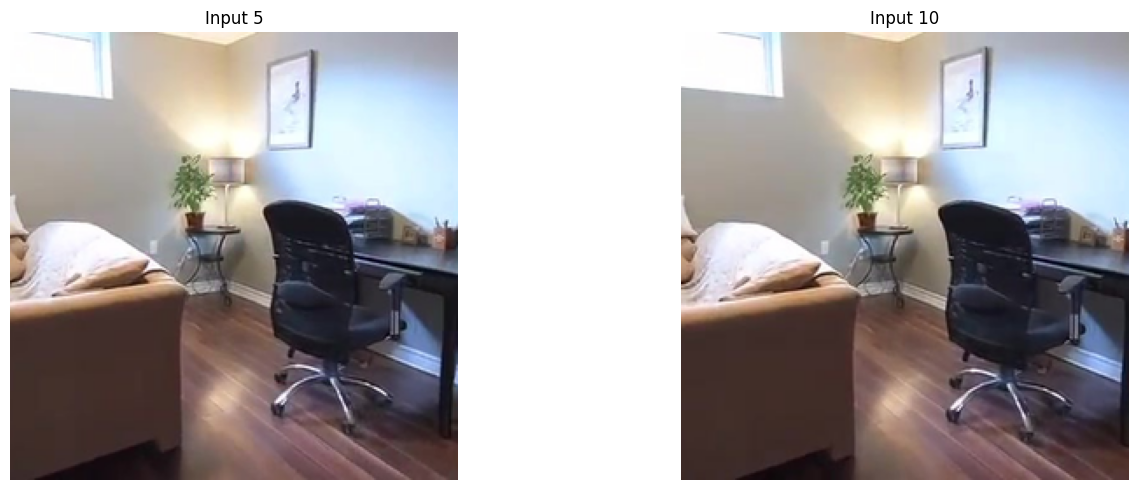


Rendered Custom View:


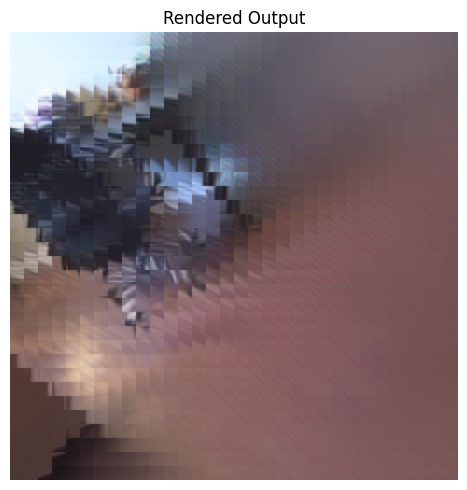

Image saved to: ./rendered_videos/model1_render.png
--- Controlled Rendering Finished ---

--- Starting Rendering for model: 'Extrapolate_RE10K_NORANDOM' ---
Scene: 25, Input Frame Indices: [5, 10]

Input Views Used:


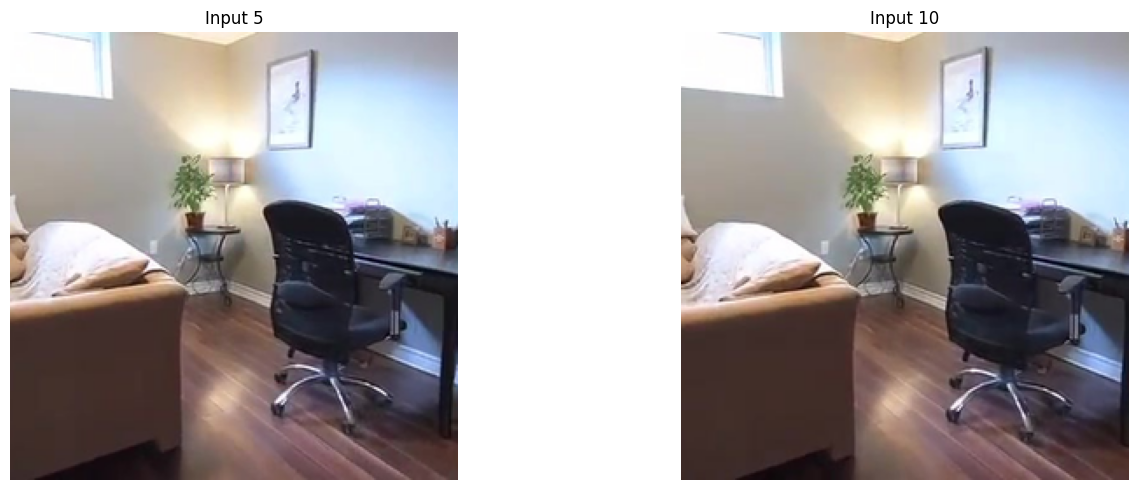


Rendered Custom View:


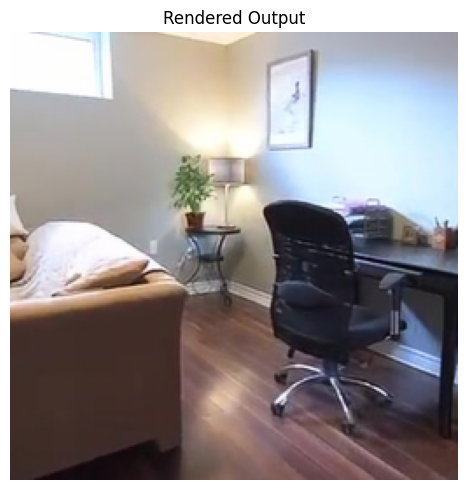

Image saved to: ./rendered_videos/model2_render.png
--- Controlled Rendering Finished ---


In [30]:
if __name__ == '__main__':
    # --- THIS IS THE MOST IMPORTANT STEP FOR REPRODUCIBILITY ---
    set_seed(42)

    # --- 1. SETUP (Load dataset once, models separately) ---
    print("Setting up dataset...")
    # The dataset is the same for both models, so we only need to load it once.
    dataset = load_dataset(CONFIG_MODEL_1["dataset_path"], CONFIG_MODEL_1["config_file"])
    print(f"Dataset loaded with {len(dataset)} scenes.")

    print("\nLoading models...")
    # --- FIX: Convert dictionaries to EasyDict objects before passing them ---
    model1 = load_model(edict(CONFIG_MODEL_1))
    model2 = load_model(edict(CONFIG_MODEL_2))
    print("Setup complete.")
    
    # --- 2. DEFINE THE TEST PARAMETERS ---
    SCENE_TO_INSPECT = 25
    render_params = {
        "scene_idx": SCENE_TO_INSPECT,
        "input_view_indices": [5,10],
        "base_camera_idx_from_input": 0,
        "tx": -1.0, "ty": 0.6, "tz": 0.2,
        "rx": 0.0, "ry": 30.0, "rz": 45.0,
    }

    # --- 3. RUN FOR MODEL 1 ---
    render_custom_view(
        model=model1,
        dataset=dataset,
        output_filename="model1_render.png",
        **render_params
    )
    
    # --- 4. RUN FOR MODEL 2 ---
    render_custom_view(
        model=model2,
        dataset=dataset,
        output_filename="model2_render.png",
        **render_params
    )